# Arbres de Décison : CITIZENSAFE

## Nous allons travailler sur la génération aléatoire des zones à surveiller par time

In [103]:
import numpy as np
import pandas as pd
from sklearn import tree
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [139]:
input_file = "C:/Users/SYLVAIN/Desktop/HETC - MD5 -2023-2024/EXO Machine-Learning/Apps_CitizenSafe/Data/Crime_Data_from_2020_to_Present.csv"
df = pd.read_csv(input_file)

In [140]:
# Choisir les colonnes
df = df[['TIME OCC', 'AREA', 'AREA NAME']]

# Regrouper par zone
df_groupby = df.groupby(['AREA NAME'], as_index=False)['AREA'].max()
df_groupby.head()

,AREA NAME,AREA
0,77th Street,12
1,Central,1
2,Devonshire,17
3,Foothill,16
4,Harbor,5


## Encoding et séparation des données

In [141]:
# La target
X = df[['TIME OCC']]
y = df['AREA']

# Séparer les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [142]:
# Création et entraînement du modèle
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Évaluation du modèle
y_pred = rf_model.predict(X_test)

In [143]:
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))


Matrice de confusion:
[[4431  147  343    7   29  239  104  225   44   28   12 2742   56 1247
    57    9   31  118   17   53   27]
 [2872  145  227    4   14  168   55  165   18   22   11 2009   26  934
    34    1   14   91   10   21   15]
 [3303  138  281    7   15  182   59  248   26   25   10 2377   45 1127
    43    2   24  102   26   35   28]
 [2303   97  175    4   13  130   47  134   19   19    9 1716   28  761
    31    4    7   63   12   18   13]
 [2540   90  188    5   22  143   63  173   33   11    8 1860   30  922
    29    1   13   64   10   38   16]
 [3510  129  247    1   14  237   79  201   37   24   11 2247   25 1021
    58    4   24   66   14   39   21]
 [2839   92  229    2   15  182   97  190   46   37   13 1890   58 1091
    59    3   31   72   14   27   28]
 [2540  120  226    2   26  147   99  291   27   33   11 1848   35 1151
    59    5   25   66   16   38   29]
 [2462  112  221    0   13  155   83  185   25   21   10 1796   28  979
    42    4   19   85   1

In [144]:
features = list(df.columns[:2])
features

['TIME OCC', 'AREA']

In [145]:
y = df["AREA"]
X = df[features]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X,y)

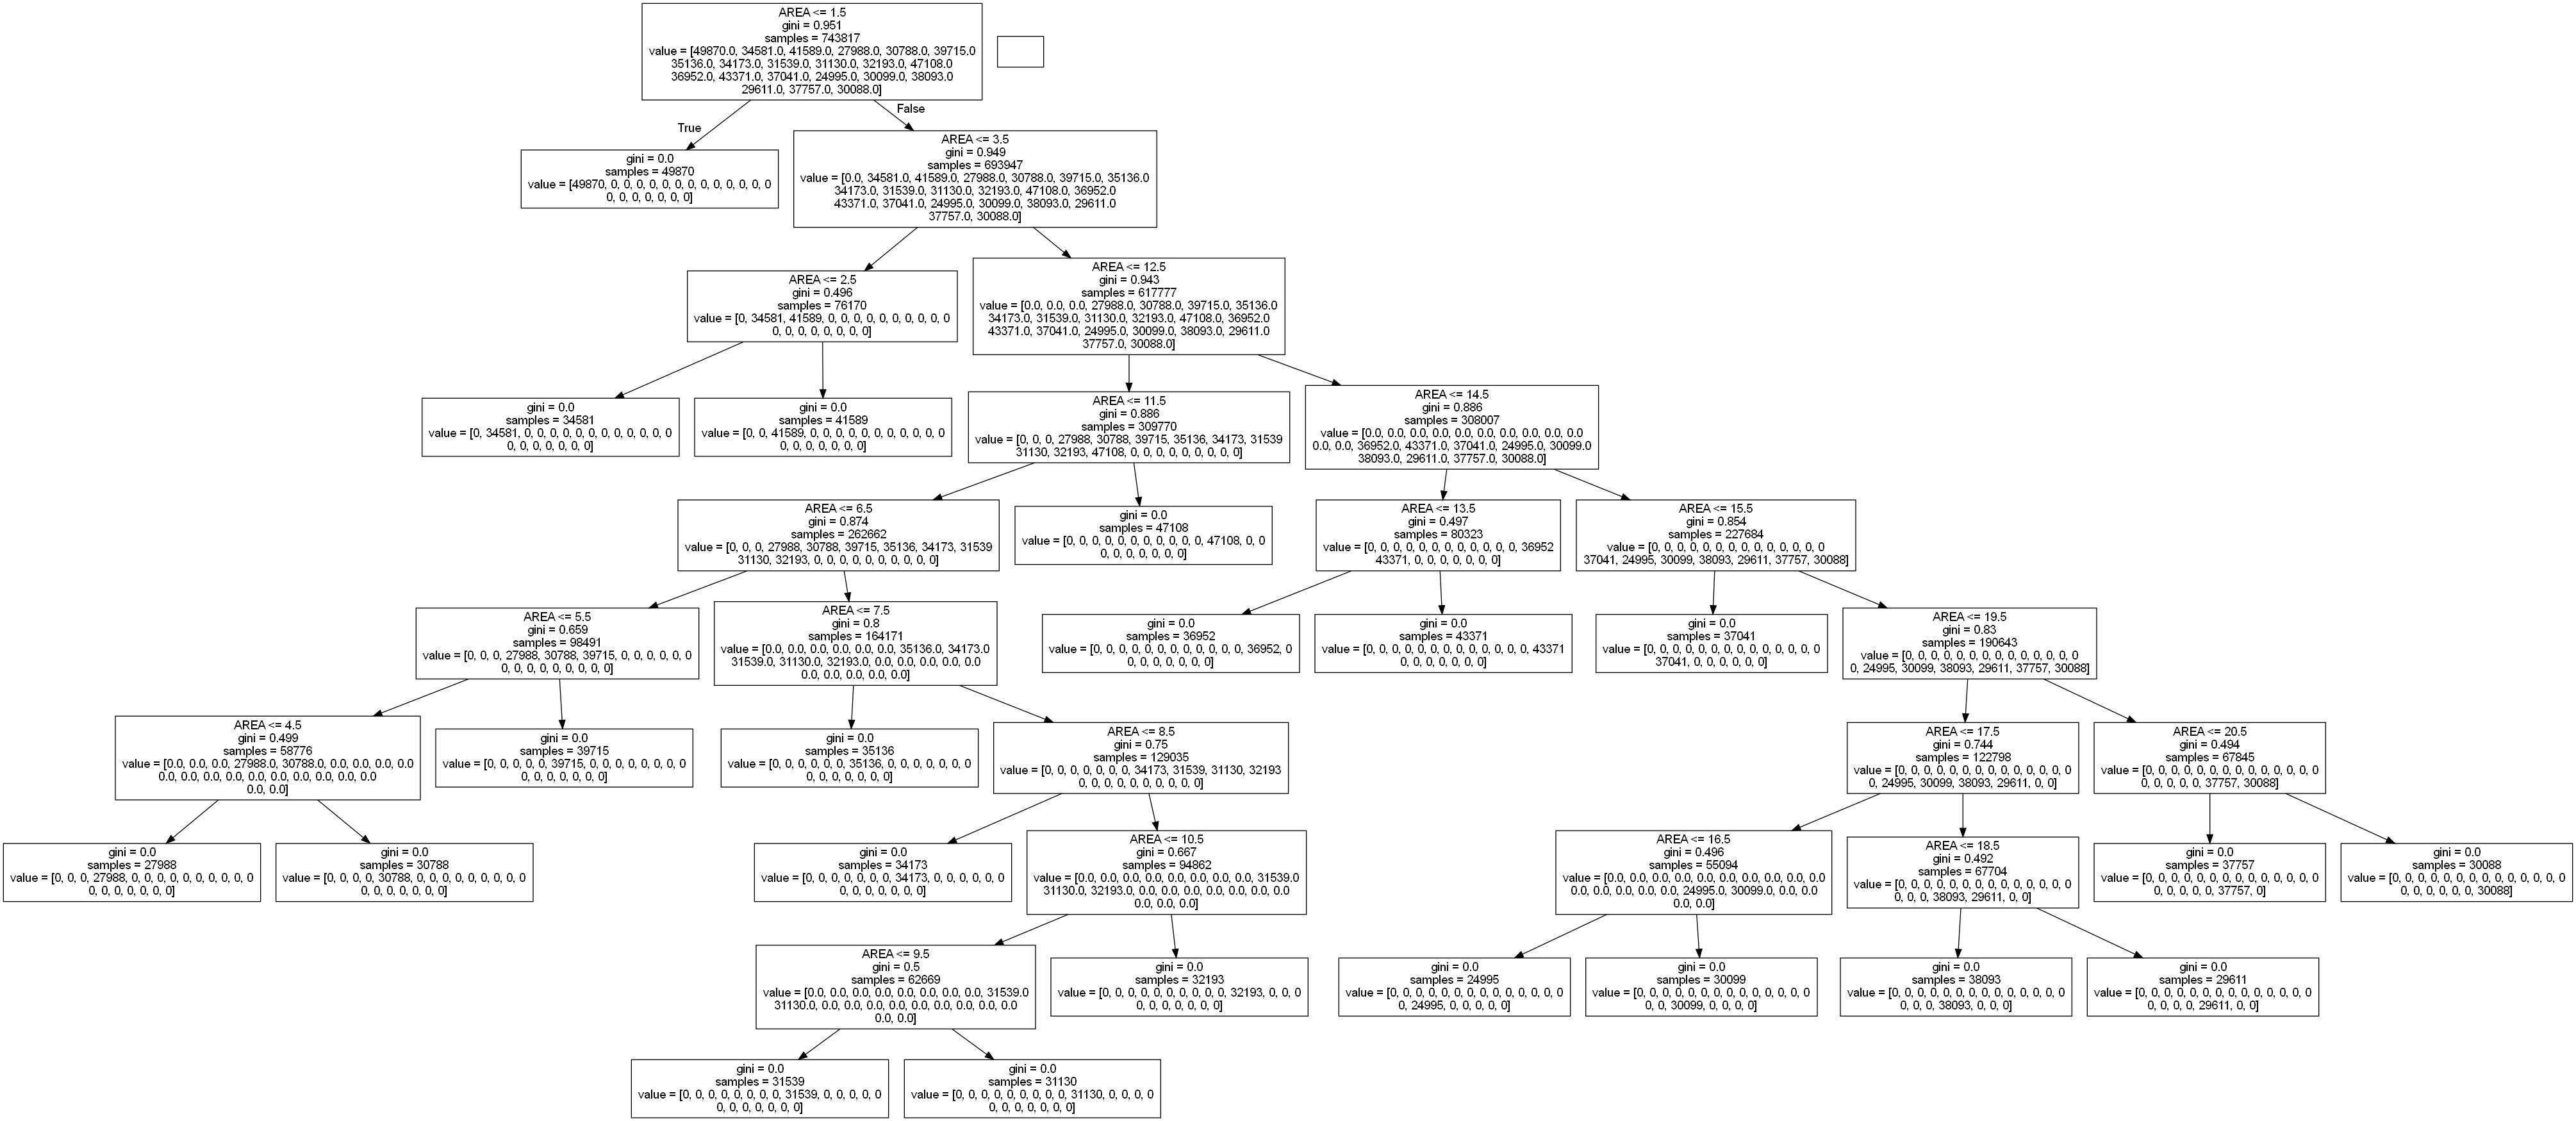

In [146]:
from IPython.display import Image  
from six import StringIO  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=features)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())  

In [ ]:
# Convertir en minutes 
#df['TIME OCC'] = df['TIME OCC'].apply(lambda x: f'{x//3600:02}:{(x%3600)//60:02}:{x%60:02}')
#df.head()

In [168]:
le = LabelEncoder()
df['AREA_ENCODED'] = le.fit_transform(df['AREA'])

# Création d'un dictionnaire pour mapper les codes de zone aux noms de zone
zone_name_map = dict(zip(df['AREA'], df['AREA NAME']))

# Fonction pour prédire les zones les plus exposées
def predict_top_zones(hour, minute, top_n=5):
    time_minutes = hour * 60 + minute
    
    # Obtenir les probabilités pour chaque zone
    probabilities = rf_model.predict_proba([[time_minutes]])[0]
    
    # Trier les zones par probabilité décroissante
    sorted_indices = np.argsort(probabilities)[::-1]
    
    # Sélectionner les top_n zones
    top_zones = le.inverse_transform(sorted_indices[:top_n])
    top_probs = probabilities[sorted_indices[:top_n]]
    
    # Obtenir les noms des zones
    top_zone_names = [zone_name_map[zone] for zone in top_zones]
    
    return list(zip(top_zone_names, top_probs))

# Fonction pour créer un DataFrame avec les prédictions
def create_prediction_dataframe(hours):
    results = []
    for hour in hours:
        zones_probs = predict_top_zones(hour, 0)
        row = {'Heure': f'{hour:02d}:00'}
        for i, (zone, prob) in enumerate(zones_probs, 1):
            row[f'Zone {i}'] = zone
            row[f'Probabilité {i}'] = f'{prob:.2f}'
        results.append(row)
    return pd.DataFrame(results)

# Heures à prédire
heures = [8, 12, 17, 22, 6]

# Créer le DataFrame
df_predictions = create_prediction_dataframe(heures)

# Afficher le DataFrame
print(df_predictions.to_string(index=False))

# Si vous voulez sauvegarder en CSV
# df_predictions.to_csv('predictions_zones.csv', index=False)

Heure      Zone 1 Probabilité 1      Zone 2 Probabilité 2      Zone 3 Probabilité 3   Zone 4 Probabilité 4    Zone 5 Probabilité 5
08:00 77th Street          0.07     Central          0.06 N Hollywood          0.06   Newton          0.06 Hollywood          0.06
12:00     Central          0.09 77th Street          0.08  Hollenbeck          0.07  Rampart          0.07 Southwest          0.06
17:00 77th Street          0.09     Central          0.09   Hollywood          0.06 Wilshire          0.06 Southwest          0.05
22:00 77th Street          0.07     Central          0.06   Southwest          0.06   Newton          0.06   Rampart          0.06
06:00 N Hollywood          0.19 West Valley          0.13    Van Nuys          0.12  Central          0.11 Hollywood          0.08


c:\Users\SYLVAIN\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\SYLVAIN\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\SYLVAIN\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\SYLVAIN\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\SYLVAIN\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Affichage

In [175]:
import matplotlib.pyplot as plt
from IPython.display import display

# Fonction pour appliquer la coloration conditionnelle
def color_probabilities(val):
    try:
        float_val = float(val)
        color = plt.cm.RdYlGn(float_val)
        return f'background-color: rgba({",".join(map(str, (int(c*255) for c in color[:3])))},.5)'
    except ValueError:
        return ''

# Appliquer le style au DataFrame
styled_df = df_predictions.style.applymap(color_probabilities, subset=[col for col in df_predictions.columns if col.startswith('Prob')])

# Définir les propriétés de style
styled_df = styled_df.set_properties(**{
    'border-color': 'black',
    'border-style': 'solid',
    'border-width': '1px',
    'text-align': 'center',
    'padding': '10px',
    'font-size': '11pt'
})

# Définir les styles spécifiques pour l'en-tête et l'index
styled_df = styled_df.set_table_styles([
    {'selector': 'th', 'props': [
        ('background-color', '#4CAF50'),
        ('color', 'white'),
        ('font-weight', 'bold'),
        ('text-align', 'left'),
        ('padding-left', '0px'),  
    ]},
    {'selector': 'td', 'props': [
        ('padding-left', '20px'),  
    ]},
])

# Afficher le DataFrame stylisé
display(styled_df)

,Heure,Zone 1,Probabilité 1,Zone 2,Probabilité 2,Zone 3,Probabilité 3,Zone 4,Probabilité 4,Zone 5,Probabilité 5
0,08:00,77th Street,0.07,Central,0.06,N Hollywood,0.06,Newton,0.06,Hollywood,0.06
1,12:00,Central,0.09,77th Street,0.08,Hollenbeck,0.07,Rampart,0.07,Southwest,0.06
2,17:00,77th Street,0.09,Central,0.09,Hollywood,0.06,Wilshire,0.06,Southwest,0.05
3,22:00,77th Street,0.07,Central,0.06,Southwest,0.06,Newton,0.06,Rampart,0.06
4,06:00,N Hollywood,0.19,West Valley,0.13,Van Nuys,0.12,Central,0.11,Hollywood,0.08


### Evaluer les performances